In [45]:
# handle data
import pyspark.sql as ps
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 

# train data|
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta

In [46]:
spark = ps.SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "4096m").\
        getOrCreate()
spark.sparkContext.setLogLevel("WARN")

In [47]:
symbol = "BTCUSDT"
PERIOD = "1d"

In [48]:
df = spark.read.parquet(f"hdfs://hadoop-namenode:9000/crypto/{symbol}/{PERIOD}.parquet")

In [49]:
pd_df = df.toPandas()

In [50]:
pd_df = pd_df.set_index("date").sort_index()

In [51]:
pd_df["open"] = pd_df["open"].apply(lambda price: float(price))

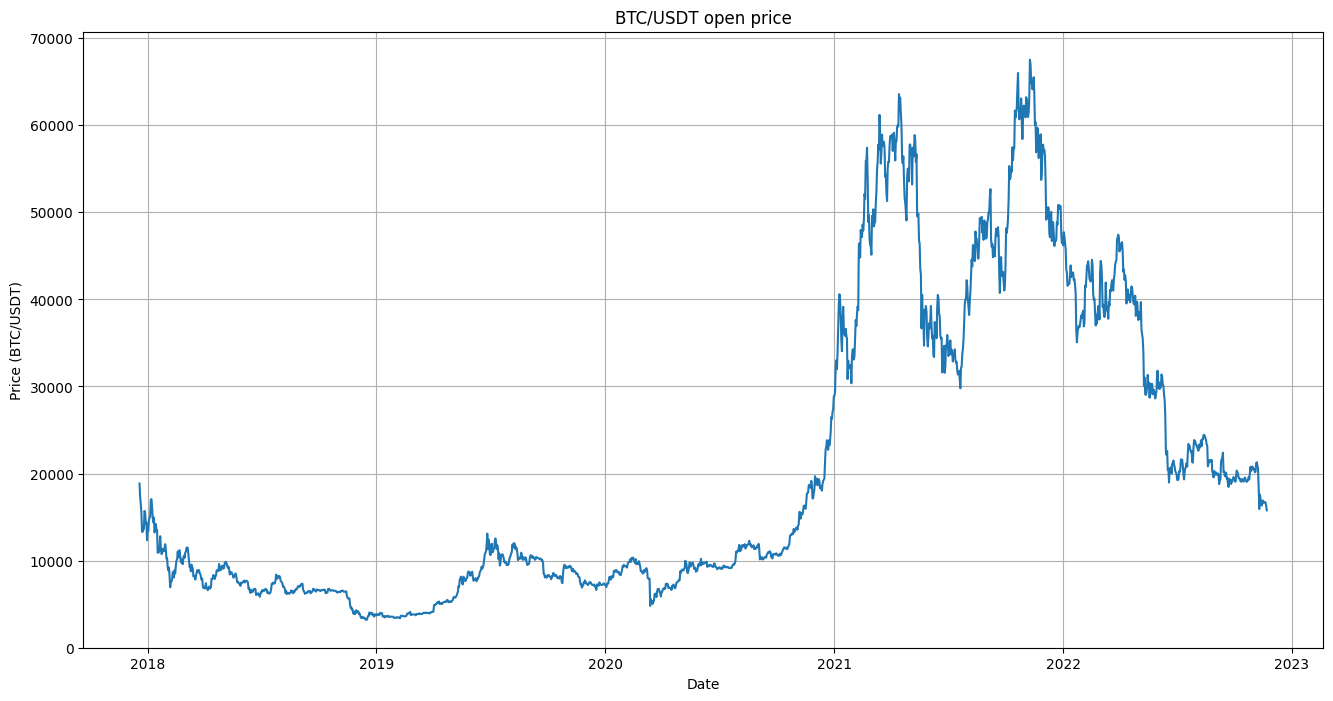

In [52]:
plt.figure(figsize=(16,8),)
plt.title("BTC/USDT open price")
plt.plot(pd_df["open"])
plt.ylabel("Price (BTC/USDT)")
plt.xlabel("Date")
plt.grid()
plt.show()

In [177]:
dataset = pd_df.filter(["open"]).values

In [178]:
TRAIN_DATA_LENGTH = int(len(dataset) * 0.8)
dataset

array([[18856.25],
       [17295.2 ],
       [16480.52],
       ...,
       [16700.68],
       [16279.5 ],
       [15781.29]])

In [179]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [180]:
scaled_data

array([[0.24325206],
       [0.21897979],
       [0.20631258],
       ...,
       [0.20973578],
       [0.20318698],
       [0.19544047]])

In [181]:
train_data = scaled_data[:TRAIN_DATA_LENGTH]

X_train = []
Y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,:])
    Y_train.append(train_data[i,:])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [192]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [193]:
model.fit(X_train, Y_train, batch_size=1, epochs=2)

Epoch 1/2
1380/1380 [==============================] - 83s 60ms/step - loss: 0.0047
Epoch 2/2
1380/1380 [==============================] - 66s 48ms/step - loss: 0.0012


In [184]:
test_data = scaled_data[TRAIN_DATA_LENGTH-60:]

X_test = []
Y_test = []
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i,:])
    Y_test.append(test_data[i,:])

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [185]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 1s 13ms/step


In [186]:
test_data.shape

(420, 1)

In [187]:
data = pd_df.filter(["open"])
train = data[:TRAIN_DATA_LENGTH]
valid = data[TRAIN_DATA_LENGTH:].reset_index()
valid["predict_price"] = predictions
valid = valid.set_index("date")
valid["predict_price"]= valid["predict_price"].apply(lambda price: float(price))

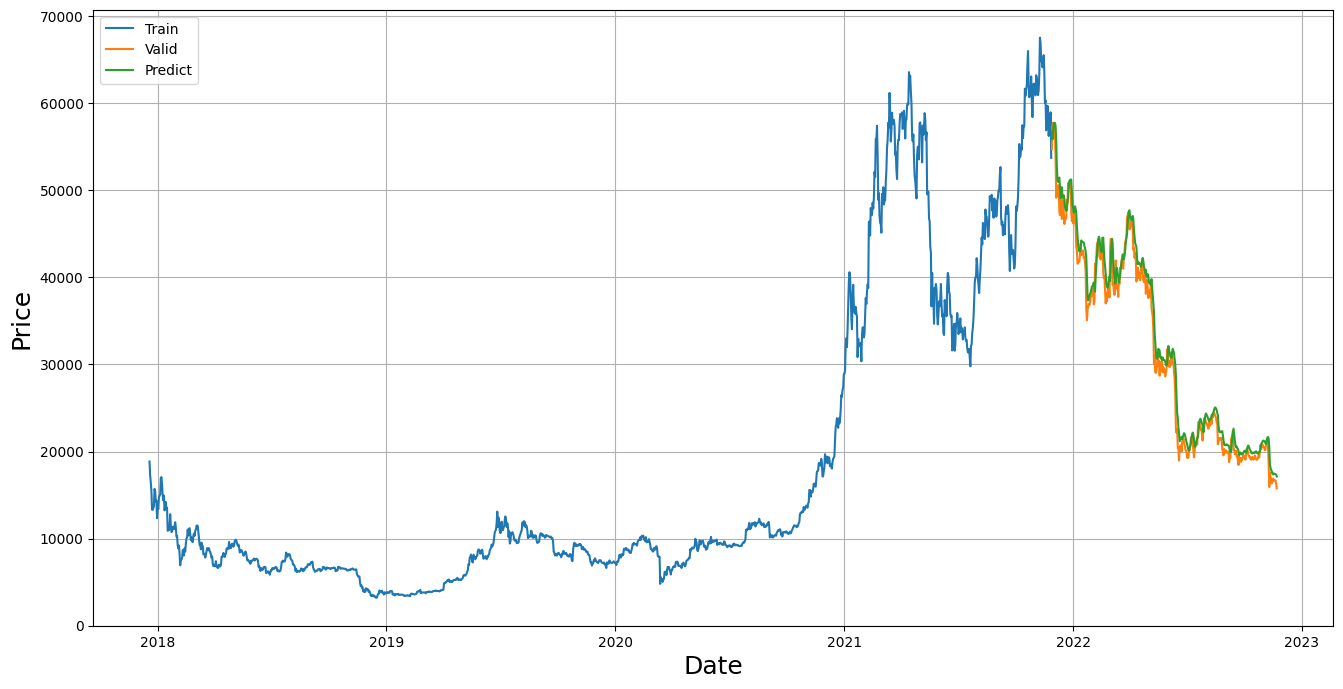

In [188]:
plt.figure(figsize=(16,8))
plt.xlabel("Date", fontsize= 18)
plt.ylabel("Price", fontsize= 18)
plt.plot(train["open"])
plt.plot(valid[["open","predict_price"]])
plt.legend(["Train","Valid", "Predict"],loc="upper left")
plt.grid()
plt.show()


In [189]:
X_test = scaled_data[-60:]
X_test = np.array(X_test)
X_test = X_test.reshape(1, 60, 1)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 19ms/step


### Recent price

In [190]:
data[-10:]

,open
date,
2022-11-13,16813.16
2022-11-14,16331.78
2022-11-15,16617.72
2022-11-16,16900.57
2022-11-17,16661.61
2022-11-18,16692.56
2022-11-19,16699.43
2022-11-20,16700.68
2022-11-21,16279.50


### Tomorrow price

In [191]:
predictions[0,0]

16767.355